In [1]:
import datetime
import numpy as np 
import itertools
import os
import io
import cv2
import seaborn as sns
import matplotlib.pyplot as plt 
from tqdm import tqdm
from keras.layers import Input,Dropout,Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback

In [2]:
labels = ['glioma','meningioma','notumor','pituitary']

x_train = [] #training images
y_train = [] #training labels
x_test = [] #testing images
y_test = [] #testing labels

image_size = 200
for label in labels:
    trainPath = os.path.join('/Users/mahiajay/Desktop/multilevel brain tumor classification/archive/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath,file),0) #Load images in gray
        image = cv2.bilateralFilter(image,2,50,50) #remove image noise
        image = cv2.applyColorMap(image,cv2.COLORMAP_BONE) #produce a pseudological image
        image = cv2.resize(image,(image_size,image_size)) # resize images into 150*150
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/Users/mahiajay/Desktop/multilevel brain tumor classification/archive/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath,file),0) #Load images in gray
        image = cv2.bilateralFilter(image,2,50,50) #remove image noise
        image = cv2.applyColorMap(image,cv2.COLORMAP_BONE) #produce a pseudological image
        image = cv2.resize(image,(image_size,image_size)) # resize images into 150*150
        x_test.append(image)
        y_test.append(labels.index(label))
x_train = np.array(x_train)/255.0 #normalize images into range 0 to 1
x_test = np.array(x_test) /255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:00<00:00, 972.66it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


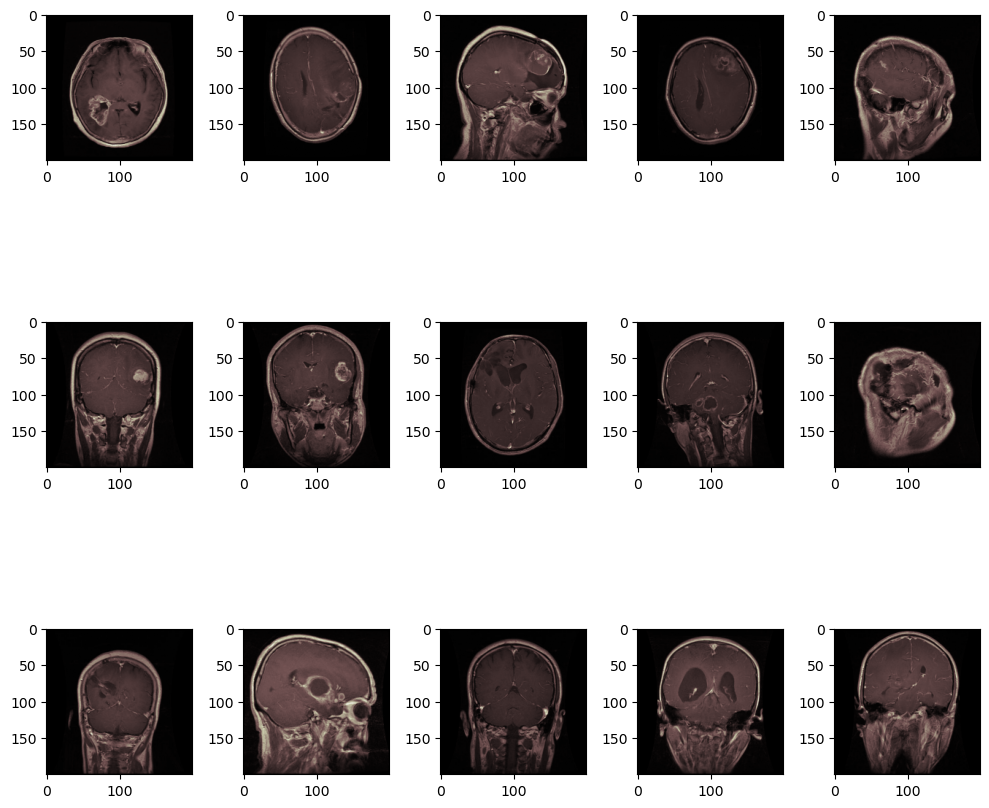

In [3]:
images = [x_train[i] for i in range(15)]
fig,axes =plt.subplots(3,5,figsize=(10,10))
axes = axes.flatten()
for img, ax in zip(images,axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [4]:
x_train,y_train =shuffle(x_train,y_train,random_state=42)

y_train = tf.keras.utils.to_categorical(y_train) #one hot encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=42) #Dividing the dataset into Training and Validation sets.

In [5]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After creating and configuring ImageDataGenerator, we will fit it on data.
datagen.fit(x_train)

In [6]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

94765736/94765736 [==============================] - 149s 2us/step


In [7]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [8]:

# Reload the TensorBoard extension
%load_ext tensorboard

class_names = list(labels)

def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure
# Create a summary writer for logging
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
file_writer_cm = tf.summary.create_file_writer(logdir)

# Following function will make predictions from the model and log the confusion matrix as an image. 
def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Remove previous log folder using Windows command
os.system('rmdir /s /q logs')
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Run TensorBoard
%tensorboard --logdir logs

rmdir: /s: No such file or directory
rmdir: /q: No such file or directory
rmdir: logs: Directory not empty


In [9]:
#create a writer variable for writing into the log folder.\n",
file_writer_cm = tf.summary.create_file_writer(logdir)
tensorboard = TensorBoard(logdir, histogram_freq=1)
        
BATCH_SIZE = 30
EPOCHS = 10
Checkpoint = ModelCheckpoint(filepath = 'model.{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)

Epoch 1/10
229/229 [==============================] - ETA: 0s - loss: 0.2958 - accuracy: 0.8938
Epoch 1: val_loss improved from inf to 2.57785, saving model to model.01-0.28-2.58.h5


/Users/mahiajay/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 611s 3s/step - loss: 0.2958 - accuracy: 0.8938 - val_loss: 2.5779 - val_accuracy: 0.2765 - lr: 1.0000e-04
Epoch 2/10
229/229 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9591
Epoch 2: val_loss did not improve from 2.57785
229/229 [==============================] - 721s 3s/step - loss: 0.1115 - accuracy: 0.9591 - val_loss: 10.3412 - val_accuracy: 0.2765 - lr: 1.0000e-04
Epoch 3/10
229/229 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9744
Epoch 3: val_loss improved from 2.57785 to 1.65182, saving model to model.03-0.46-1.65.h5


/Users/mahiajay/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 773s 3s/step - loss: 0.0694 - accuracy: 0.9744 - val_loss: 1.6518 - val_accuracy: 0.4646 - lr: 1.0000e-04
Epoch 4/10
229/229 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9783
Epoch 4: val_loss improved from 1.65182 to 0.41804, saving model to model.04-0.85-0.42.h5


/Users/mahiajay/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 795s 3s/step - loss: 0.0741 - accuracy: 0.9783 - val_loss: 0.4180 - val_accuracy: 0.8539 - lr: 1.0000e-04
Epoch 5/10
229/229 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9821
Epoch 5: val_loss improved from 0.41804 to 0.11201, saving model to model.05-0.96-0.11.h5


/Users/mahiajay/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 666s 3s/step - loss: 0.0557 - accuracy: 0.9821 - val_loss: 0.1120 - val_accuracy: 0.9624 - lr: 1.0000e-04
Epoch 6/10
229/229 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9891
Epoch 6: val_loss improved from 0.11201 to 0.10420, saving model to model.06-0.97-0.10.h5


/Users/mahiajay/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 668s 3s/step - loss: 0.0317 - accuracy: 0.9891 - val_loss: 0.1042 - val_accuracy: 0.9676 - lr: 1.0000e-04
Epoch 7/10
229/229 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9873
Epoch 7: val_loss improved from 0.10420 to 0.08610, saving model to model.07-0.98-0.09.h5


/Users/mahiajay/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 660s 3s/step - loss: 0.0357 - accuracy: 0.9873 - val_loss: 0.0861 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 8/10
229/229 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9886
Epoch 8: val_loss did not improve from 0.08610
229/229 [==============================] - 715s 3s/step - loss: 0.0349 - accuracy: 0.9886 - val_loss: 0.3757 - val_accuracy: 0.9046 - lr: 1.0000e-04
Epoch 9/10
229/229 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9895
Epoch 9: val_loss did not improve from 0.08610
229/229 [==============================] - 704s 3s/step - loss: 0.0290 - accuracy: 0.9895 - val_loss: 0.0964 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 10/10
229/229 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9888
Epoch 10: val_loss did not improve from 0.08610
229/229 [==============================] - 711s 3s/step - loss: 0.0319 - accuracy: 0.9888 - val_loss: 0.1581 - val_accurac

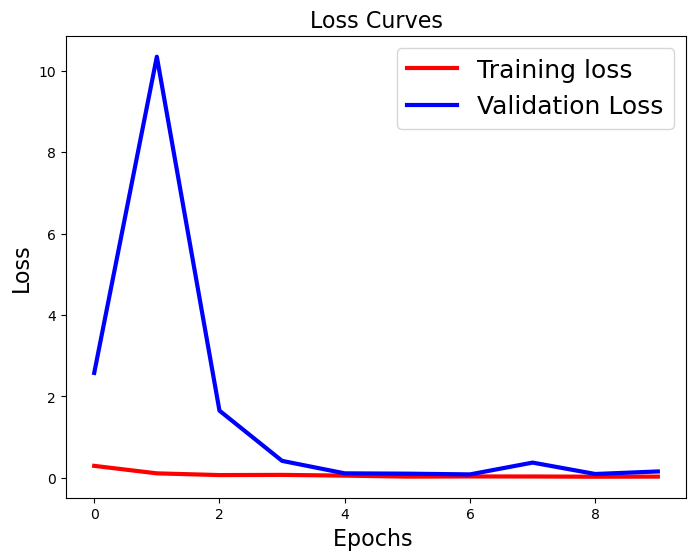

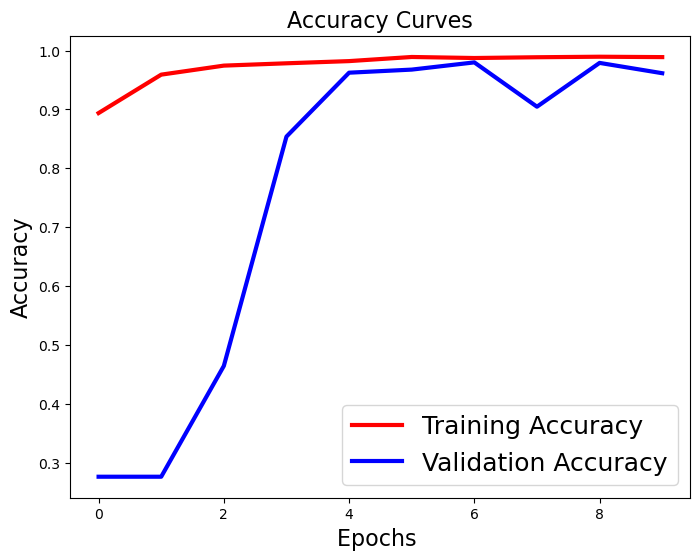

In [10]:

#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

41/41 [==============================] - 28s 686ms/step
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       300
           1       0.97      0.95      0.96       306
           2       0.99      1.00      0.99       405
           3       0.99      0.95      0.97       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



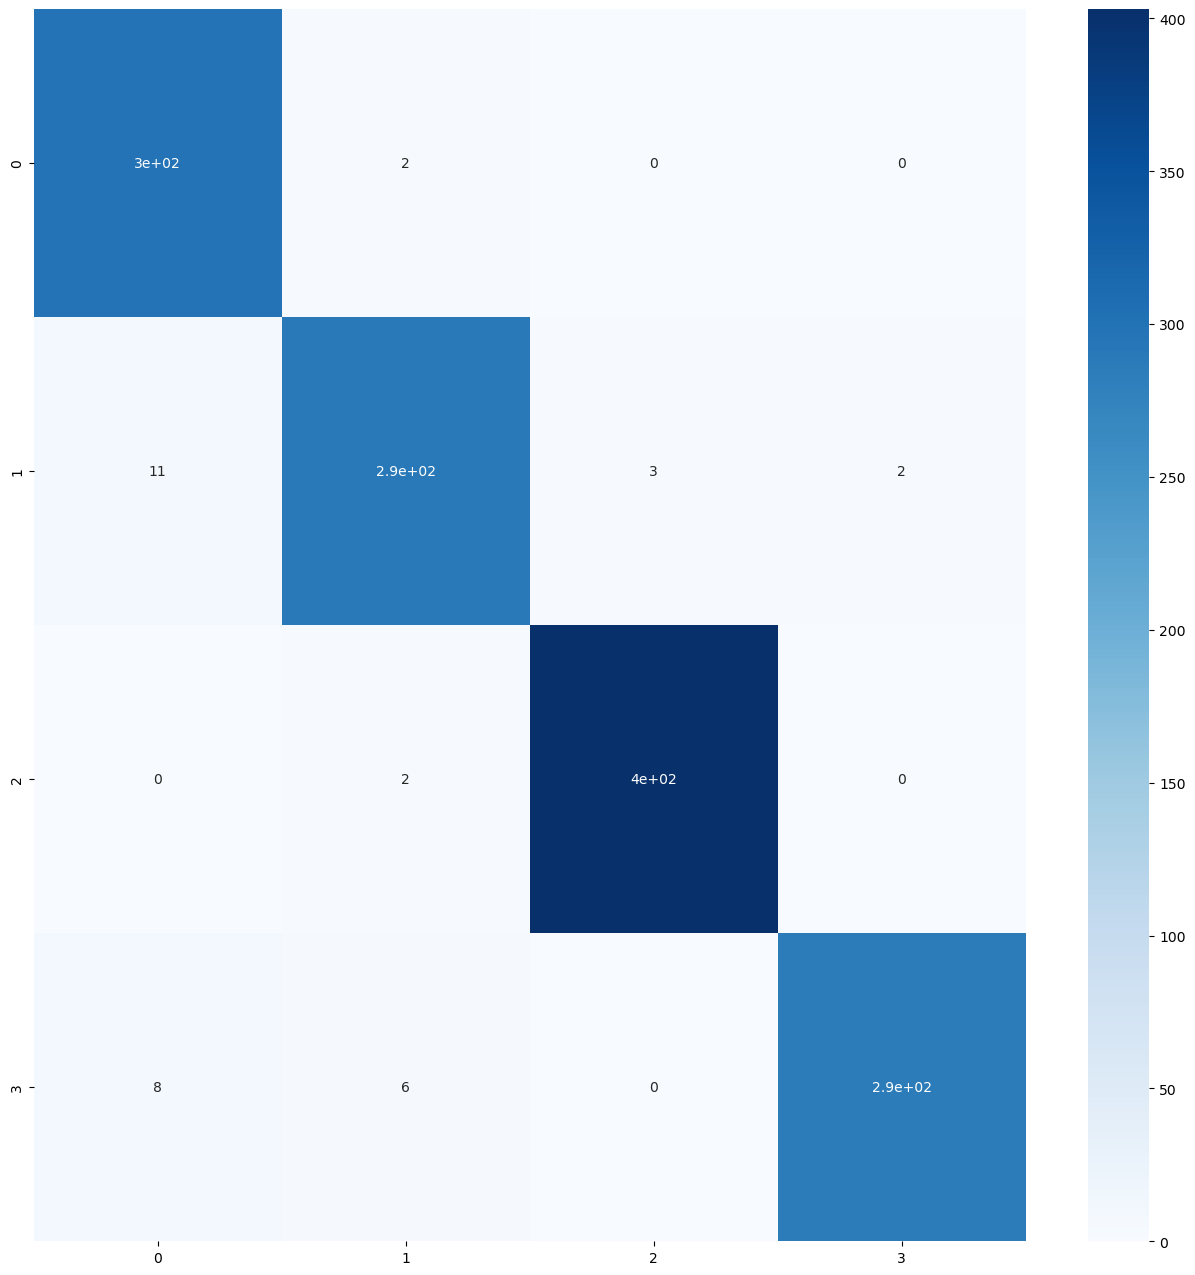

In [11]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [12]:
loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 29s 706ms/step - loss: 0.0997 - accuracy: 0.9741
